# Context:
#### Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

### Attribute Information:
- userId : Every user identified with a unique id
- productId : Every product identified with a unique id
- Rating : Rating of the corresponding product by the corresponding user
- timestamp : Time of the rating ( ignore this column for this exercise)

## Steps and tasks:
1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics) - (3 Marks)
2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings ) - (3 Marks)
3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) - (3 Marks)
4. Build Popularity Recommender model. - (20 Marks)
5. Build Collaborative Filtering model. - (20 Marks)
6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.) - (7 Marks)
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products. - (7 Marks)
8. Summarise your insights. - (7 Marks)


## <font color=blue>1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)<font>

### Import the required Librarries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import random
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings; warnings.simplefilter('ignore')

In [2]:
# Load the dataset from csv file
df_ratings = pd.read_csv('ratings_Electronics.csv')

In [ ]:
#For working With Google Colab
#import pandas as pd
#import io
#url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Electronics.csv'
#df_ratings = pd.read_csv(url)

In [3]:
# Explore the datatsets
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
AKM1MP6P0OYPR    object
0132793040       object
5.0              float64
1365811200       int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [4]:
# Rename the columns
df_ratings.columns = ['userId', 'productId', 'Rating', 'timestamp']

In [5]:
#Check the Data after Loading
df_ratings.head()

,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [6]:
# Checking for missing value
print ("Count of null values in each feature:")
print(df_ratings.isna().sum())

Count of null values in each feature:
userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


#### Observation: There are no missing values for any features

In [7]:
#characteristics of the data
print (df_ratings.dtypes)

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object


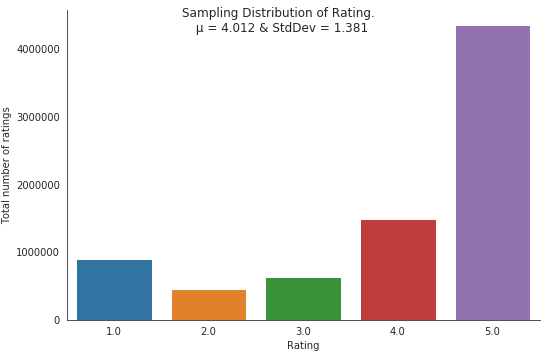

In [8]:
# Check the distribution of ratings of original Data
mu = round(df_ratings.Rating.describe().loc['mean'], 3) # mean of distribution
sigma = round(df_ratings.Rating.describe().loc['std'],3) # standard deviation of distribution
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=df_ratings, aspect=1.5,kind='count')
    g.set_ylabels("Total number of ratings") 
    g.fig.suptitle(f"Sampling Distribution of Rating. \n \u03bc = {mu} & StdDev = {sigma}")

In [9]:
#Basic Statistics of the DataSet Given
df_ratings['Rating'].describe()

count    7.824481e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

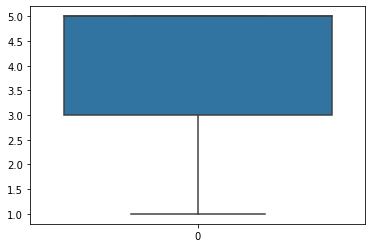

In [10]:
sns.boxplot(data=df_ratings['Rating'])

In [11]:
# Let us look at the no of 'Rating' given by various user
ratings_dist = df_ratings[['Rating','userId']].groupby(['Rating']).count()
ratings_dist.reset_index(inplace=True)
ratings_dist.columns = ['Rating', 'ratecount']
ratings_dist

,Rating,ratecount
0,1.0,901765
1,2.0,456322
2,3.0,633073
3,4.0,1485781
4,5.0,4347540


In [12]:
## Calculate the % of Distribution of Rating
ratings_dist['proportion'] = ratings_dist['ratecount'] / sum(ratings_dist['ratecount'])
ratings_dist

,Rating,ratecount,proportion
0,1.0,901765,0.115249
1,2.0,456322,0.058320
2,3.0,633073,0.080909
3,4.0,1485781,0.189889
4,5.0,4347540,0.555633


### Observation: 
####    1. Rating has a mean value of 4.01 and Std of 1.38, ranging 1 to 5 and skewed towards higher rating of 4 & 5
####    2. Total Number of Entries is very High, Total 7824480 entries
####    3. About 55.56% of Data has Rating of 5 and 18.98% of Data has Rating of 4, combindly it is Approx 74.5%
####    4. Data is very sparse and Will tend towards Rating of 4/5 if we use this for Recomendation

## <font color='blue'>2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings ) - (3 Marks)</font>

In [13]:
## Target Variable Rating count w.r.t userId
user_rate_dist = df_ratings['userId'].value_counts().to_frame() ## IT need to convert to frame as value_counts return Series 
user_rate_dist.reset_index(inplace=True)
user_rate_dist.columns = [user_rate_dist.columns[1], 'ratecount']
user_rate_dist['proportion'] = user_rate_dist['ratecount'] / sum(user_rate_dist['ratecount'])
user_rate_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4201696 entries, 0 to 4201695
Data columns (total 3 columns):
userId        object
ratecount     int64
proportion    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 96.2+ MB


In [14]:
# Get the users who have rated >= 50 items.
user_rate_dist_50 = user_rate_dist[user_rate_dist['ratecount']>= 50]
user_rate_dist_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1540 entries, 0 to 1539
Data columns (total 3 columns):
userId        1540 non-null object
ratecount     1540 non-null int64
proportion    1540 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 48.1+ KB


### Observation: 
#### - From Unique 4201696 users in the Whole Dataset Reduced to 1540 Unique Users who has rated more than or Equal to 50 times

In [15]:
# Gets the filtered Data set from Main Dataset with the Users who has rated more than 50 times.
df_ratings_filt=df_ratings.copy() #Best Practice to Make Copy of Original Dataset
df_ratings_filt=df_ratings_filt.merge(user_rate_dist_50['userId'], on='userId', how='right')
df_ratings_filt['userId'].shape

(125871,)

In [16]:
#Checking the Data - Original
df_ratings.head(1)

,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800


In [17]:
#Checking the Data - Filtered By User Rated >=50
df_ratings_filt.head(1)

,userId,productId,Rating,timestamp
0,A3BY5KCNQZXV5U,0594451647,5.0,1390176000


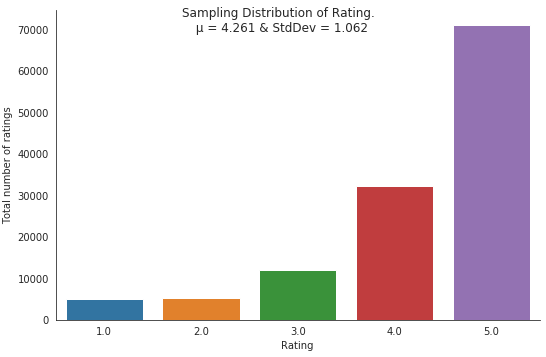

In [18]:
# Check the distribution of ratings of Data - Filtered By User Rated >=50
mu = round(df_ratings_filt.Rating.describe().loc['mean'], 3) # mean of distribution
sigma = round(df_ratings_filt.Rating.describe().loc['std'],3) # standard deviation of distribution
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=df_ratings_filt, aspect=1.5,kind='count')
    g.set_ylabels("Total number of ratings") 
    g.fig.suptitle(f"Sampling Distribution of Rating. \n \u03bc = {mu} & StdDev = {sigma}")

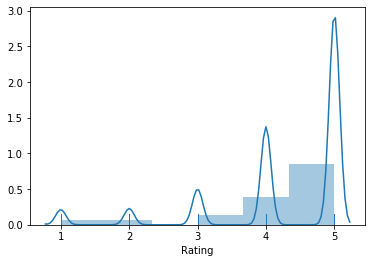

In [19]:
sns.distplot(df_ratings_filt['Rating'],hist = True,bins=6,kde = True,rug = True, label = 'Rating')

In [20]:
#Basic Statistics Data - Filtered By User Rated >=50
df_ratings_filt['Rating'].describe()

count    125871.000000
mean          4.261339
std           1.062144
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

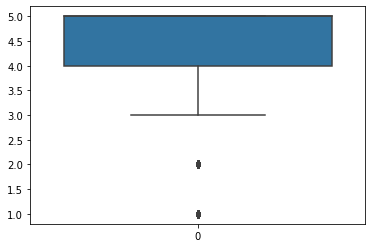

In [21]:
sns.boxplot(data=df_ratings_filt['Rating'])

### Observation: 
#### - After Filtering By Rating Count total Data count has reduced to 125871 from earlier 7824480
#### - Due to distribution of Rating Data it is showing Outliers for Rating 1 and 2

In [22]:
## Target Variable Rating count w.r.t userId who rated >=50
sub_ratings_dist = df_ratings_filt['Rating'].value_counts().to_frame()
sub_ratings_dist.reset_index(inplace=True)
sub_ratings_dist.columns = [sub_ratings_dist.columns[1], 'ratecount']
sub_ratings_dist['proportion'] = sub_ratings_dist['ratecount'] / sum(sub_ratings_dist['ratecount'])
sub_ratings_dist

,Rating,ratecount,proportion
0,5.0,71034,0.564340
1,4.0,32295,0.256572
2,3.0,12060,0.095812
3,2.0,5367,0.042639
4,1.0,5115,0.040637


In [23]:
# % of users who have rating count (< 1000)
print('% of users who have rating count (< 50): ',((7824480-125871)/7824480)*100)

% of users who have rating count (< 50):  98.39131801729955


## Observations:

#### - % of users who have rating count (< 50) 98.39%, which is quite high.
#### - Due to Spareness will not consider these users who have rated <50 items.
#### - We have reduced no of data 125871 compared to original set of Data of 7824480 by Not Considering them
#### - Mean value and Std has also changed, currently mean = 4.26 and Std=1.06
#### - High frequency is still towards high rating.


## <font color='blue'>3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) - (3 Marks)</font>

In [24]:
# Dropping the timestamp column as we will not be using in our predictions also keep a copy of data without sparseness
df_ratings_train_split=df_ratings_filt.copy() #Make a copy of the Filtered Data Where Rating Count >=50 for Further Analysins
df_ratings_train_split.drop('timestamp', axis = 1, inplace = True)

In [25]:
df_ratings_train_split.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 0 to 125870
Data columns (total 3 columns):
userId       125871 non-null object
productId    125871 non-null object
Rating       125871 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


In [26]:
df_ratings_train_split.head()

,userId,productId,Rating
0,A3BY5KCNQZXV5U,0594451647,5.0
1,A3BY5KCNQZXV5U,B00000JD4V,4.0
2,A3BY5KCNQZXV5U,B000063574,5.0
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0
4,A3BY5KCNQZXV5U,B0007Y794O,5.0


In [27]:
# Now to split the data into Random Train, Test we will use sklearn model selection package here.
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_ratings_train_split, test_size = 0.30, random_state=20) #split it in 70/30 ratio


In [28]:
print(train_data.shape)
print(test_data.shape)

(88109, 3)
(37762, 3)


In [29]:
train_data.head()

,userId,productId,Rating
61349,A2BUQ240COLAOP,B007SLDF7O,5.0
21328,A2WDCAMKCCP1UR,B00IDDVLDG,1.0
24845,A1FF2PLA84KNAE,B001NZ8PHQ,4.0
47945,AIJQU979J6UFY,B00EPY0QVU,4.0
104765,A2EN82VBJT44QP,B0096W1OCG,4.0


In [30]:
test_data.head()

,userId,productId,Rating
25018,ARTA78TP6H73D,B00F93IOR4,5.0
67716,A7FDGFK0KN7QG,B00HXE4GZQ,5.0
41028,A3UW23DBF2KHWC,B007TN0IGM,5.0
114976,A3VC74TJ06WDDD,B000CC6I5W,1.0
41148,A3D2VIUT2HWP0Z,B001CHHVCU,5.0


In [31]:
# Checking for missing value in Splitted Data
print ("Count of null values in each feature:")
print(train_data.isna().sum())

Count of null values in each feature:
userId       0
productId    0
Rating       0
dtype: int64


In [32]:
# Checking for missing value
print ("Count of null values in each feature:")
print(test_data.isna().sum())

Count of null values in each feature:
userId       0
productId    0
Rating       0
dtype: int64


### Observation:
#### - We have splitted the data into train and test (70:30)
#### - Train and Test Data are randomly selected, it is verified with the head and looking into the index no for the selected Data
#### - I have used the random_state=20 for making the train/Test data repetative with the same order
#### - Test and Train Data do not have any null values

## <font color='blue'>4. Build Popularity Recommender model. - (20 Marks)</font>

### (Non-personalised)

In [33]:
# Getting mean ratings for each product
train_data_mean=train_data.groupby('productId')['Rating'].mean().reset_index()
# Renaming it as mean_rating column
train_data_mean.rename(columns = {'Rating': 'mean_rating'}, inplace = True)
#Resetting the index
train_data_mean.reset_index()
#See the Data
train_data_mean

,productId,mean_rating
0,0594451647,5.00
1,0594481813,3.00
2,0970407998,4.00
3,0972683275,4.75
4,1400501466,3.00
...,...,...
38260,B00LED02VY,4.00
38261,B00LGN7Y3G,5.00
38262,B00LGQ6HL8,5.00
38263,B00LI4ZZO8,5.00


In [34]:
#Popularity Recommendation based on mean Rating
train_data_mean_reco = train_data_mean.sort_values(by='mean_rating', ascending = False)
#Recomending based on Mean Rating of 5
train_data_mean_reco[train_data_mean_reco['mean_rating']>=5]

,productId,mean_rating
0,0594451647,5.0
20671,B003SW13WQ,5.0
20690,B003SXI1UM,5.0
20686,B003SX0OU2,5.0
20685,B003SX0OR0,5.0
...,...,...
11575,B0014KRVQQ,5.0
10885,B0010HGFM4,5.0
10724,B000YIWR8G,5.0
10260,B000VVXNZW,5.0


### Observation:
#### - In Popularity ased Recommendation, it is possible to recommend a product based on its highest mean Rating.
#### - Concern here is We are not considering the Rating Count given by the Users for each of This Product
#### - It Might possible Some Product is recomended by only few users with all 5 and that will appear on top
#### - Total no of Product with Mean Rating of 5 is comming 17273, which may change when we do consider the no of rating given
#### - We can apply a Score and then rank it based on Highest to Lowest Order of (Mean_rating*No Of Rating) in subsequent steps

## <center>Lets Consider the User Rating Counts Aling with the Rating also to Consider the Recomendation</center>

In [35]:
#Get the No of Product Rating Count By User Rated for the Same Product
train_data_count=train_data.groupby('productId')['userId'].count()
train_data_count=train_data_count.reset_index()
#Rename the Column userId as no_of_rating
train_data_count.rename(columns = {'userId': 'no_of_rating'}, inplace = True)
train_data_count

,productId,no_of_rating
0,0594451647,1
1,0594481813,1
2,0970407998,1
3,0972683275,4
4,1400501466,5
...,...,...
38260,B00LED02VY,1
38261,B00LGN7Y3G,1
38262,B00LGQ6HL8,3
38263,B00LI4ZZO8,1


In [36]:
# merge the data set with Mean Rating and No of Rating based on productId
train_data_score=pd.merge(train_data_mean,train_data_count,on='productId',how='inner')
train_data_score

,productId,mean_rating,no_of_rating
0,0594451647,5.00,1
1,0594481813,3.00,1
2,0970407998,4.00,1
3,0972683275,4.75,4
4,1400501466,3.00,5
...,...,...,...
38260,B00LED02VY,4.00,1
38261,B00LGN7Y3G,5.00,1
38262,B00LGQ6HL8,5.00,3
38263,B00LI4ZZO8,5.00,1


In [37]:
# Calculate the Score as mean_rating*no_of_rating
train_data_score['score'] = train_data_score['mean_rating']*train_data_score['no_of_rating']
train_data_score

,productId,mean_rating,no_of_rating,score
0,0594451647,5.00,1,5.0
1,0594481813,3.00,1,3.0
2,0970407998,4.00,1,4.0
3,0972683275,4.75,4,19.0
4,1400501466,3.00,5,15.0
...,...,...,...,...
38260,B00LED02VY,4.00,1,4.0
38261,B00LGN7Y3G,5.00,1,5.0
38262,B00LGQ6HL8,5.00,3,15.0
38263,B00LI4ZZO8,5.00,1,5.0


In [38]:
# Calculate the Rank based on Highest Score of (mean_rating*no_of_rating)
train_data_score['rank'] = train_data_score['score'].rank(ascending = False, method = 'first')
train_data_score = train_data_score.sort_values(by='rank')
# Get the top 10 recommendations 
popularity_recommendations = train_data_score.head(10) 
popularity_recommendations

,productId,mean_rating,no_of_rating,score,rank
30943,B0088CJT4U,4.234483,145,614.0,1.0
19698,B003ES5ZUU,4.865079,126,613.0,2.0
30344,B007WTAJTO,4.738095,126,597.0,3.0
8741,B000N99BBC,4.754098,122,580.0,4.0
30635,B00829THK0,4.447619,105,467.0,5.0
30639,B00829TIEK,4.500000,96,432.0,6.0
22810,B004CLYEDC,4.626506,83,384.0,7.0
17797,B002V88HFE,4.725000,80,378.0,8.0
31202,B008DWCRQW,4.097826,92,377.0,9.0
17411,B002R5AM7C,4.177778,90,376.0,10.0


In [39]:
# Lets consider 3 random User to recommend
random_3_user=random.choices(test_data['userId'].unique(), k=3)
random_3_user

['A1C47ROOK7BSVL', 'A2DIQTZPF26T1L', 'A19UTUEBWKIZFT']

In [40]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [41]:
find_recom = random_3_user   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))
    print("\n") 

Here is the recommendation for the userId: A1C47ROOK7BSVL

               userId   productId  mean_rating  no_of_rating  score  rank
30943  A1C47ROOK7BSVL  B0088CJT4U     4.234483           145  614.0   1.0
19698  A1C47ROOK7BSVL  B003ES5ZUU     4.865079           126  613.0   2.0
30344  A1C47ROOK7BSVL  B007WTAJTO     4.738095           126  597.0   3.0
8741   A1C47ROOK7BSVL  B000N99BBC     4.754098           122  580.0   4.0
30635  A1C47ROOK7BSVL  B00829THK0     4.447619           105  467.0   5.0
30639  A1C47ROOK7BSVL  B00829TIEK     4.500000            96  432.0   6.0
22810  A1C47ROOK7BSVL  B004CLYEDC     4.626506            83  384.0   7.0
17797  A1C47ROOK7BSVL  B002V88HFE     4.725000            80  378.0   8.0
31202  A1C47ROOK7BSVL  B008DWCRQW     4.097826            92  377.0   9.0
17411  A1C47ROOK7BSVL  B002R5AM7C     4.177778            90  376.0  10.0


Here is the recommendation for the userId: A2DIQTZPF26T1L

               userId   productId  mean_rating  no_of_rating  scor

### Observation:
#### - Since this is a popularity-based recommender model, recommendations remain the same for all users

#### - We predict the products based on the popularity. It is not personalized to particular user

#### <font color=orange>Reference: Popularity Recommendation using External class, "[Recommenders.py](https://github.com/llSourcell/recommender_live/blob/master/Recommenders.py)" </font>

#### <font color=orange> I am Also building the Model here using the Recommenders class [as outlined in this article](https://analyticsindiamag.com/beginners-guide-to-building-a-song-recommender-in-python/) to do the Popularity Based Recomendation </font>

#### <font color=orange>Other Popularity recomendation Model I found is [graphlab recommender](https://www.analyticsvidhya.com/blog/2016/06/quick-guide-build-recommendation-engine-python/) functions popularity_recommender, though I am going here with [Recommenders class](https://github.com/llSourcell/recommender_live/blob/master/Recommenders.py)"</font> 

In [42]:
# Dropping the timestamp column as we will not be using in our predictions also keep a copy of data without sparseness
df_ratings_train_split=df_ratings_filt.copy()
df_ratings_train_split.drop('timestamp', axis = 1, inplace = True)

In [43]:
# Now to split the data into Random Train, Test we will use sklearn model selection package here.

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_ratings_train_split, test_size = 0.30, random_state=20)

In [44]:
print(train_data)
print(test_data)

                userId   productId  Rating
61349   A2BUQ240COLAOP  B007SLDF7O     5.0
21328   A2WDCAMKCCP1UR  B00IDDVLDG     1.0
24845   A1FF2PLA84KNAE  B001NZ8PHQ     4.0
47945    AIJQU979J6UFY  B00EPY0QVU     4.0
104765  A2EN82VBJT44QP  B0096W1OCG     4.0
...                ...         ...     ...
88988   A2EHYCA29NSQLU  B00E3FHXYO     4.0
23775   A33152QEGO2MZN  B009SYZ8OC     3.0
37135   A1ODOGXEYECQQ8  B0002HA7FY     5.0
92634   A1987V5OCO6QHS  B009W3WHDO     1.0
114019   AWPN47SSWK1JV  B00AR95FP4     4.0

[88109 rows x 3 columns]
                userId   productId  Rating
25018    ARTA78TP6H73D  B00F93IOR4     5.0
67716    A7FDGFK0KN7QG  B00HXE4GZQ     5.0
41028   A3UW23DBF2KHWC  B007TN0IGM     5.0
114976  A3VC74TJ06WDDD  B000CC6I5W     1.0
41148   A3D2VIUT2HWP0Z  B001CHHVCU     5.0
...                ...         ...     ...
35167    A6VPK7X53QNAQ  B000IF51UQ     4.0
77680   A213J54E63SYOP  B000I1GZ28     4.0
44542    ALDAF4VVLFRHP  B001F7AHOG     5.0
28911   A23ONMGKEWDG4M  B000

In [45]:
# For Working with Google Colab
# Link- https://github.com/llSourcell/recommender_live/blob/master/Recommenders.py
#! git clone https://github.com/llSourcell/recommender_live
#%cd recommender_live 

In [46]:
## I have Downloaded Recommenders file into source code directory#

# Building a Popularity Based Recommendation Systems
import Recommenders as Recommenders
pm = Recommenders.popularity_recommender_py()

In [47]:
# Renaming the Column as I want to use the class as it is instead of Modifying the class, being it a External Library
train_data.rename(columns = {'Rating': 'score'}, inplace = True)
train_data.rename(columns = {'userId': 'user_id'}, inplace = True)
train_data.rename(columns = {'productId': 'item_id'}, inplace = True)
train_data_sub=train_data[['user_id','item_id','score']]
train_data_sub

,user_id,item_id,score
61349,A2BUQ240COLAOP,B007SLDF7O,5.0
21328,A2WDCAMKCCP1UR,B00IDDVLDG,1.0
24845,A1FF2PLA84KNAE,B001NZ8PHQ,4.0
47945,AIJQU979J6UFY,B00EPY0QVU,4.0
104765,A2EN82VBJT44QP,B0096W1OCG,4.0
...,...,...,...
88988,A2EHYCA29NSQLU,B00E3FHXYO,4.0
23775,A33152QEGO2MZN,B009SYZ8OC,3.0
37135,A1ODOGXEYECQQ8,B0002HA7FY,5.0
92634,A1987V5OCO6QHS,B009W3WHDO,1.0


In [48]:
pm.create(train_data_sub,'user_id','item_id')

In [49]:
users = train_data_sub['user_id'].unique()
users,len(users)

(array(['A2BUQ240COLAOP', 'A2WDCAMKCCP1UR', 'A1FF2PLA84KNAE', ...,
        'A35HOUWHAYZZN6', 'A4GGT6O0GQNV2', 'A2DF62DP20RIXF'], dtype=object),
 1540)

In [50]:
# Get the Recomendation for a randomly picked user from User 51
user_id = users[51]
print('User Id------',user_id)
pm.recommend(user_id)

User Id------ A15U64VGUV6RBF


,user_id,item_id,score,Rank
30943,A15U64VGUV6RBF,B0088CJT4U,145,1.0
19698,A15U64VGUV6RBF,B003ES5ZUU,126,2.0
30344,A15U64VGUV6RBF,B007WTAJTO,126,3.0
8741,A15U64VGUV6RBF,B000N99BBC,122,4.0
30635,A15U64VGUV6RBF,B00829THK0,105,5.0
30639,A15U64VGUV6RBF,B00829TIEK,96,6.0
31202,A15U64VGUV6RBF,B008DWCRQW,92,7.0
17411,A15U64VGUV6RBF,B002R5AM7C,90,8.0
17591,A15U64VGUV6RBF,B002SZEOLG,85,9.0
22810,A15U64VGUV6RBF,B004CLYEDC,83,10.0


In [51]:
# Get the Recomendation for a randomly picked user from User 71
user_id = users[71]
print('User Id------',user_id)
pm.recommend(user_id)

User Id------ A2WXURU33RBGQS


,user_id,item_id,score,Rank
30943,A2WXURU33RBGQS,B0088CJT4U,145,1.0
19698,A2WXURU33RBGQS,B003ES5ZUU,126,2.0
30344,A2WXURU33RBGQS,B007WTAJTO,126,3.0
8741,A2WXURU33RBGQS,B000N99BBC,122,4.0
30635,A2WXURU33RBGQS,B00829THK0,105,5.0
30639,A2WXURU33RBGQS,B00829TIEK,96,6.0
31202,A2WXURU33RBGQS,B008DWCRQW,92,7.0
17411,A2WXURU33RBGQS,B002R5AM7C,90,8.0
17591,A2WXURU33RBGQS,B002SZEOLG,85,9.0
22810,A2WXURU33RBGQS,B004CLYEDC,83,10.0


In [52]:
# Align the column Name same as Trin Data for Test Data to be used for prediction
test_data.rename(columns = {'userId': 'user_id'}, inplace = True)
test_data.rename(columns = {'Rating': 'score'}, inplace = True)
test_data.rename(columns = {'productId': 'item_id'}, inplace = True)
test_data

,user_id,item_id,score
25018,ARTA78TP6H73D,B00F93IOR4,5.0
67716,A7FDGFK0KN7QG,B00HXE4GZQ,5.0
41028,A3UW23DBF2KHWC,B007TN0IGM,5.0
114976,A3VC74TJ06WDDD,B000CC6I5W,1.0
41148,A3D2VIUT2HWP0Z,B001CHHVCU,5.0
...,...,...,...
35167,A6VPK7X53QNAQ,B000IF51UQ,4.0
77680,A213J54E63SYOP,B000I1GZ28,4.0
44542,ALDAF4VVLFRHP,B001F7AHOG,5.0
28911,A23ONMGKEWDG4M,B00063ZVJQ,5.0


In [53]:
# Funtion to get mean RMSE for the Popularity Recommender model for random 10 users in test data.
def GetpmRMSE():
    uuid = test_data['user_id'].unique()
    rand_uuid = random.sample(list(uuid), 10)
    print('rand_uuid',rand_uuid)
    arr_RMSE = []
    RMSE = -1
    for ruid in rand_uuid:
        #print (ruid)
        UserPred = pm.recommend(ruid)
        #print ("UIID: " + str(len(UserPred)))
        Actual = test_data[test_data.user_id == ruid]
        UserPred = UserPred[UserPred['item_id'].isin(Actual['item_id'].unique())]
        Actual = Actual[Actual['item_id'].isin(UserPred['item_id'].unique())]
        uiid = Actual['item_id'].unique()
        #print ("UIID: " + str(len(uiid)))
        if len(uiid) > 0:
            arr_Actual = []
            arr_Pred = []
            score = 0
            error = 0
            for uid in uiid:
                score = Actual[Actual.item_id == uid]['score']
                arr_Actual.append(score.values[0])
                score = UserPred[UserPred.item_id == uid]['score']
                arr_Pred.append(score.values[0])
                error = sqrt(mean_squared_error(arr_Actual, arr_Pred))
                if(error!=np.NaN):
                  arr_RMSE.append(error)
                  #print ('error',error)
    RMSE = np.average(arr_RMSE)
    return RMSE

In [54]:
# Evaluation for Popularity Model.

# This function will get the predictions for 100 random users in test dataset and will calculate the RMSE.
print("Popularity Model RMSE: ", GetpmRMSE())

rand_uuid ['AKT8TGIT6VVZ5', 'A1CMD08Z49PGKQ', 'A3DWO5RJDA430F', 'A3HXGSMCIOZEW8', 'A4WEZJOIZIV4U', 'AIBRTGBN07D6A', 'A4S2WAQVQR6PI', 'A11YIHB6IW352W', 'A2ROZACRW31PC2', 'A2AFTRU43PY9P5']
Popularity Model RMSE:  121.19909133937792


## <font color=blue>5. Build Collaborative Filtering model. - (20 Marks)</font>

####  <i>Take the subset of the original dataset to make it less sparse/ denser as caluclulated earlier and use the same for Collaborative Filtering Model Also</i>

### Model-based Collaborative Filtering: Singular Value Decomposition

#### <font color=orange>We will use [surprise](http://surpriselib.com/) toolkit is used for Collaborative Filtering model.</font>

In [55]:
# Import all the necessary surprise toolkit modules...
!pip install scikit-surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [56]:
df_ratings_train_split=df_ratings_filt.copy() # Get a Copy of Filtered Data of User Rating Count >=50
df_ratings_train_split.drop('timestamp', axis = 1, inplace = True)
df_ratings_train_split

,userId,productId,Rating
0,A3BY5KCNQZXV5U,0594451647,5.0
1,A3BY5KCNQZXV5U,B00000JD4V,4.0
2,A3BY5KCNQZXV5U,B000063574,5.0
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0
4,A3BY5KCNQZXV5U,B0007Y794O,5.0
...,...,...,...
125866,A328S9RN3U5M68,B00JGL37FO,5.0
125867,A328S9RN3U5M68,B00K00FN3O,5.0
125868,A328S9RN3U5M68,B00L21HC7A,5.0
125869,A328S9RN3U5M68,B00L2442H0,5.0


In [57]:
# Lets load the dataset as per the requirement for surprise module
reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(df_ratings_train_split[['userId','productId','Rating']], reader = reader)

In [58]:
# Lets split the train and test with surprise model functionality
trainset, testset = train_test_split(data, test_size=.3, random_state=20)
print('trainset',trainset.n_items)
print('testset',len(testset))

trainset 38180
testset 37762


### Lets Begin with the famous SVD algorithm.

In [59]:
from surprise import SVD

algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)
print(predictions[0],' And ','predictions made',len(predictions))
# Then compute RMSE
rmse_svd=accuracy.rmse(predictions)
print('rmse_svd:',rmse_svd)

user: A3D0UM4ZD2CMAW item: B004PGAMJY r_ui = 5.00   est = 4.89   {'was_impossible': False}  And  predictions made 37762
RMSE: 0.9823
rmse_svd: 0.9823050317068356


### Use cross-validation iterators

In [60]:
from surprise.model_selection import KFold
# define a cross-validation iterator
kf = KFold(n_splits=3)
algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.9882
RMSE: 0.9829
RMSE: 0.9867


## Lets go with KNN algorithm

In [61]:
df_ratings_train_split=df_ratings_filt.copy() # Get a Copy of Filtered Data of User Rating Count >=50
df_ratings_train_split.drop('timestamp', axis = 1, inplace = True)
df_ratings_train_split

,userId,productId,Rating
0,A3BY5KCNQZXV5U,0594451647,5.0
1,A3BY5KCNQZXV5U,B00000JD4V,4.0
2,A3BY5KCNQZXV5U,B000063574,5.0
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0
4,A3BY5KCNQZXV5U,B0007Y794O,5.0
...,...,...,...
125866,A328S9RN3U5M68,B00JGL37FO,5.0
125867,A328S9RN3U5M68,B00K00FN3O,5.0
125868,A328S9RN3U5M68,B00L21HC7A,5.0
125869,A328S9RN3U5M68,B00L2442H0,5.0


In [62]:
# Lets load the dataset as per the requirement for surprise module
reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(df_ratings_train_split[['userId','productId','Rating']], reader = reader)

In [63]:
# Lets split the train and test with surprise model functionality
trainset, testset = train_test_split(data, test_size=.3, random_state=20)
print('trainset',trainset.n_items)
print('testset',len(testset))

trainset 38180
testset 37762


### User-Based collaborative filtering

In [64]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
#from surprise import KNNBasic
#algo = KNNBasic()
# Train the model with train dataset
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [65]:
testset[0:5]

[('A3D0UM4ZD2CMAW', 'B004PGAMJY', 5.0),
 ('A3VI2VETB90ZG5', 'B00DEYHLF6', 3.0),
 ('A2LB4FLRZG6CUV', 'B0096E3MTC', 5.0),
 ('A3EX8ZFNVDHGPM', 'B00B1OQUS0', 5.0),
 ('A1MRPX3RM48T2I', 'B000WL6YY8', 4.0)]

In [66]:
# we can now query for specific predicions lets say for #3rd User
uid = str(testset[3][0])  # raw user id
iid = str(testset[3][1])  # raw item id
# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: A3EX8ZFNVDHGPM item: B00B1OQUS0 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


In [67]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [68]:
#Checking of the Data
test_pred[0:10]

[Prediction(uid='A3D0UM4ZD2CMAW', iid='B004PGAMJY', r_ui=5.0, est=4.260041539456809, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3VI2VETB90ZG5', iid='B00DEYHLF6', r_ui=3.0, est=4.396825396825397, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2LB4FLRZG6CUV', iid='B0096E3MTC', r_ui=5.0, est=4.260041539456809, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3EX8ZFNVDHGPM', iid='B00B1OQUS0', r_ui=5.0, est=4.260041539456809, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1MRPX3RM48T2I', iid='B000WL6YY8', r_ui=4.0, est=4.4361702127659575, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3ER6ARJ23CIN8', iid='B007HISGRW', r_ui=3.0, est=4.260041539456809, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2L9OPJAAEK08Q', iid='B000E6G9RI', r_ui=3.0, est=3.576923076923077

In [69]:
# get RMSE
rmse_user_user_colab=accuracy.rmse(test_pred, verbose=True)
print('RMSE with User/User Based Colab Filtering:',rmse_user_user_colab)

RMSE: 1.0579
RMSE with User/User Based Colab Filtering: 1.0578935580447755


### Item-Based collaborative filtering

In [70]:
df_ratings_train_split=df_ratings_filt.copy() # Get a Copy of Filtered Data of User Rating Count >=50
df_ratings_train_split.drop('timestamp', axis = 1, inplace = True)
df_ratings_train_split

,userId,productId,Rating
0,A3BY5KCNQZXV5U,0594451647,5.0
1,A3BY5KCNQZXV5U,B00000JD4V,4.0
2,A3BY5KCNQZXV5U,B000063574,5.0
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0
4,A3BY5KCNQZXV5U,B0007Y794O,5.0
...,...,...,...
125866,A328S9RN3U5M68,B00JGL37FO,5.0
125867,A328S9RN3U5M68,B00K00FN3O,5.0
125868,A328S9RN3U5M68,B00L21HC7A,5.0
125869,A328S9RN3U5M68,B00L2442H0,5.0


### <font color=orange>After Trying with Rating Count of 50 and Above, due to More number of Combination to do the Item-Item Filtering Model and System crashed showing Low Memory, Even Trying with Google Colab Failed.</font>
#### <font color=orange>After a Number of Iteration, I am considering the Rating Count of More than 150 for item - item Filtering and Trying with Colab as well as My System, it did not collapse.</font>

In [71]:
# Get the users who have rated >= 150 items.
user_rate_dist_150 = user_rate_dist[user_rate_dist['ratecount']>= 150]
user_rate_dist_150.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 3 columns):
userId        99 non-null object
ratecount     99 non-null int64
proportion    99 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ KB


In [72]:
# Gets the filtered Data set with the Users who has rated more than 50 times.
df_ratings_filt_150=df_ratings.copy()
df_ratings_filt_150=df_ratings_filt_150.merge(user_rate_dist_150['userId'], on='userId', how='right')
len(df_ratings_filt_150['userId'])

21960

In [73]:
# Lets load the dataset as per the requirement for surprise module
reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(df_ratings_filt_150[['userId','productId','Rating']], reader = reader)

In [74]:
# Lets split the train and test with surprise model functionality
trainset, testset = train_test_split(data, test_size=.3, random_state=20)
print('trainset',trainset.n_items)
print('testset',len(testset))

trainset 10344
testset 6588


In [75]:
#from surprise import KNNBasic
#algo = KNNBasic() # Not Cosidering the KNNBasic Rather Trying with KNNMeans
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False}) #Already Imported Library
# Train the model with train dataset
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [76]:
#from google.colab import drive
#drive.mount('/content/drive')

In [77]:
testset[0:5]

[('A25C2M3QF9G7OQ', 'B001CE5LNY', 5.0),
 ('ADLVFFE4VBT8', 'B0041BT21M', 5.0),
 ('A2NB2E5DXE319Z', 'B008HO9DIG', 5.0),
 ('A22CW0ZHY3NJH8', 'B00IEUCW6S', 4.0),
 ('A4WEZJOIZIV4U', 'B003UE52ME', 5.0)]

In [78]:
# we can now query for specific predicions lets say for #3rd User
uid = str(testset[3][0])  # raw user id
iid = str(testset[3][1])  # raw item id
# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: A22CW0ZHY3NJH8 item: B00IEUCW6S r_ui = None   est = 4.35   {'actual_k': 2, 'was_impossible': False}


In [79]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [80]:
# Checking of the Data
test_pred[0:10]

[Prediction(uid='A25C2M3QF9G7OQ', iid='B001CE5LNY', r_ui=5.0, est=4.31928181108509, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='ADLVFFE4VBT8', iid='B0041BT21M', r_ui=5.0, est=4.31928181108509, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2NB2E5DXE319Z', iid='B008HO9DIG', r_ui=5.0, est=4.31928181108509, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A22CW0ZHY3NJH8', iid='B00IEUCW6S', r_ui=4.0, est=4.354161611416041, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A4WEZJOIZIV4U', iid='B003UE52ME', r_ui=5.0, est=5, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A2XRMQA6PJ5ZJ8', iid='B0000AW0QQ', r_ui=5.0, est=4.31928181108509, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AT28RL25Q2OLK', iid='B000EXHYKW', r_ui=5.0, est=4.31928181108509, details={'was_impossible

In [81]:
# get RMSE
rmse_item_item_colab=accuracy.rmse(test_pred, verbose=True)
print('RMSE with Item/Item Based Based Colab Filtering:',rmse_item_item_colab)

RMSE: 1.0503
RMSE with Item/Item Based Based Colab Filtering: 1.0503424557973395


## <font color=blue>6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.) - (7 Marks)</font>

In [82]:
# Evaluation for Popularity Model.

# This function will get the predictions for 10 random users in test dataset and will calculate the RMSE.
print("RMSE with Popularity Model : ", GetpmRMSE())

rand_uuid ['A3F3B1JPACN215', 'A3Q4TYJVAM4IRM', 'A22S7D0LP8GRDH', 'A2KOV8XWZOZ0FQ', 'A30UP2KKD5IQEP', 'A30KPB2ILF6K6J', 'A2DXENZNO2JT4F', 'AI2AOCTC8BQVZ', 'A2YEOR4XJ8N3QE', 'AVU1ILDDYW301']
RMSE with Popularity Model :  115.35066849384927


In [83]:
# Evaluation for Collaborative Filtering Model.
print('RMSE with SVD:',rmse_svd)
print('RMSE with User/User Based Colab Filtering:',rmse_user_user_colab)
print('RMSE with Item/Item Based Colab Filtering:',rmse_item_item_colab)

RMSE with SVD: 0.9823050317068356
RMSE with User/User Based Colab Filtering: 1.0578935580447755
RMSE with Item/Item Based Colab Filtering: 1.0503424557973395


## Observations:

#### - Collaborative model have given the better accuracy (less error) than Popularity Model.
#### - In Collaborative model SVD is having low RMSE compared to user/user or item/item Filtering.
#### - Item/Item is more resource intensive compared to user/user filtering, Couldnot run with ratecount of 50 or More no of data with the resources I have on my Laptop as well as in Google Colab.
#### - Item/Item is comparatively gives better prediction than User/User Filtering.

## <font color=blue>7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products. - ( 7 Marks)</font>

#### <font color=orange>Source Ref: https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user</font>


In [84]:
from collections import defaultdict
#Using Top Recomendation By Surprise
def get_top_n(predictions, n):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
#        print(uid, iid, true_r, est, _)
        top_n[uid].append((iid, est))
#    print(top_n)
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [85]:
# convert results to dataframe
k=5
top_5=get_top_n(test_pred, k)
recomended_df=pd.DataFrame(top_5).T
#recomended_df.index='userId'
recomended_df

,0,1,2,3,4
A25C2M3QF9G7OQ,"(B002WE6D44, 5)","(B007ZZ6OW6, 5)","(B00KCXRMKG, 5)","(B00A48ZCVA, 5)","(B00009XVCZ, 5)"
ADLVFFE4VBT8,"(B0014Z29OU, 5)","(B003ES5ZSW, 5)","(B005KQ2O26, 5)","(B00FSDKBYY, 5)","(B005EWB37S, 5)"
A2NB2E5DXE319Z,"(B002WE6D44, 5)","(B004TS2AOS, 5)","(B000WR3Z3A, 5)","(B008JJLW4M, 5)","(B005EWB37S, 5)"
A22CW0ZHY3NJH8,"(B00CRGJJHU, 5)","(B000QWEN5K, 5)","(B000M2TAN4, 5)","(B0002KKIUA, 5)","(B00GJYJFKM, 5)"
A4WEZJOIZIV4U,"(B003UE52ME, 5)","(B00019OWU4, 5)","(B008OZF9SQ, 5)","(B0052L77QW, 5)","(B0002XQJFA, 5)"
...,...,...,...,...,...
A3V7D0LH8L7BG0,"(B0025VKUQQ, 5)","(B000YOLUPG, 5)","(B001CCLBSA, 5)","(B000QWEN5K, 5)","(B00BOHNYTW, 5)"
A36K2N527TXXJN,"(B008X9Z44M, 5)","(B00F6E4HXG, 5)","(B00104XCVO, 5)","(B008ULPAT2, 5)","(B0047ZH0B6, 5)"
AT6CZDCP4TRGA,"(B0002KVQBA, 5)","(B0023FTRUO, 5)","(B009NB8WR0, 5)","(B00E0EY7Z6, 5)","(B003ES5ZUU, 5)"
A1T1YSCDW0PD25,"(B00JWXTOIA, 5)","(B00JTU88Y2, 5)","(B00007IFED, 5)","(B00A0ABQLM, 5)","(B00008AWKZ, 5)"


In [86]:
# Printing the Data Userwise Recommended Product and Their Rating in Text Format from the recomended data frame
C=3  #Print only 3 from recomended_df list change the value to recomended_df.shape[0] if you want to print for al User
i=0
print('Print only first 3 from recomended_df, Change the Value of C to print More or All Users Recomended Product\n')
for data in top_5:
  i=i+1
  if(i<=C):
      print('Recomendation For User: ',data)
      data_dict = top_5[data]
      data_list = list(data_dict)
      for listi in data_list:
        tupl=listi
        print('With Product : ',tupl[0], ' Rating: ',tupl[1])
      print('\n')


Print only first 3 from recomended_df, Change the Value of C to print More or All Users Recomended Product

Recomendation For User:  A25C2M3QF9G7OQ
With Product :  B002WE6D44  Rating:  5
With Product :  B007ZZ6OW6  Rating:  5
With Product :  B00KCXRMKG  Rating:  5
With Product :  B00A48ZCVA  Rating:  5
With Product :  B00009XVCZ  Rating:  5


Recomendation For User:  ADLVFFE4VBT8
With Product :  B0014Z29OU  Rating:  5
With Product :  B003ES5ZSW  Rating:  5
With Product :  B005KQ2O26  Rating:  5
With Product :  B00FSDKBYY  Rating:  5
With Product :  B005EWB37S  Rating:  5


Recomendation For User:  A2NB2E5DXE319Z
With Product :  B002WE6D44  Rating:  5
With Product :  B004TS2AOS  Rating:  5
With Product :  B000WR3Z3A  Rating:  5
With Product :  B008JJLW4M  Rating:  5
With Product :  B005EWB37S  Rating:  5




## <font color=blue>8. Summarize your insights. - (7 Marks)</font>

### - Popularity Model gives similar recommendation to all users.
### - It is based on popularity of the items rather than user specific.
### - Collaborative model have given the better accuracy (less error) than Popularity Model.
### - Collaborative Model gives user specific recommendations as it is based on user-user(Similar Minded User)  or item-item(A User Likes an Item will prefer similar Item) characteristics to recommend similar products.
### - So Collaborative Filtering model will give precise recommendation than Popularity Model. It was evident with the RMSE scores of each models.
### - In Collaborative model SVD is having low RMSE compared to user/user or item/item Filtering.
### - Item/Item is more resource intensive compared to user/user filtering, Couldnot run with more no of data with the resources I have on my PC as well as in Google Colab.
### - Item/Item is comparatively gives better prediction than User/User Filtering.